In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [2]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [18]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import torch.optim as optim
import gym
from random import randint

In [19]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.l1 = nn.Linear(state_size,150)
        self.l2 = nn.Linear(150,50)
        
        self.adv = nn.Linear(50, action_size)
        
        self.val = nn.Linear(50,1)
    def forward(self, state):
        state = F.relu(self.l1(state))
        state = F.relu(self.l2(state))
        advantage = self.adv(state)
        state = self.val(state) + (advantage - torch.mean(advantage))
        return state

In [20]:
class Agent():
  def __init__(self, state_space, action_space, gamma):
    self.Q_Net = QNetwork(state_space,action_space)
    self.Q_Target = deepcopy(self.Q_Net)
    self.state_space = state_space
    self.action_space = action_space
    self.gamma = gamma
    self.optimizer = optim.Adam(self.Q_Net.parameters(), lr=0.001)
    self.scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, 0.998)#Multiplies learning rate by 0.998 every game
    self.epsilon = 30
    
  def get_action(self, s):
    #picks action using the epsilon greedy algorithm
    if randint(0,100) > self.epsilon:
      Q_Vals = self.Q_Net(torch.from_numpy(s).float())
      return torch.argmax(Q_Vals)
    else:
      return randint(0,self.action_space - 1)

  def train_state(self, s0, s1, action, reward, done):
    Q_Vals = self.Q_Net(torch.from_numpy(s0).float())
    Target_Q_Vals = self.Q_Target(torch.from_numpy(s1).float())
    Next_Q_Vals = self.Q_Net(torch.from_numpy(s1).float())
    #Uses Double DQN
    if done:
      update_loss = (Q_Vals[action] - reward)**2
    else:
      update_loss = (Q_Vals[action] - self.gamma * Target_Q_Vals[torch.argmax(Next_Q_Vals)] - reward)**2
    return update_loss
  def update_target(self):
    self.Q_Target = deepcopy(self.Q_Net)

In [21]:
agent = Agent(37,4, 0.98)

num_episodes = 1500
batch_size = 16
update_frequency = 4
T_update_frequency = 10

In [22]:
#Trains agent
state_list = list()
action_list = list()
done_list = list()
reward_list = list()
next_state_list = list()
indexes = list()
prob_list = list()
b =  0.6
a = 0.9

score_list = list()
score = 0

for episode in range(num_episodes):
  done = False
  env_info = env.reset(train_mode=True)[brain_name]
  s0 = env_info.vector_observations[0]       
  ep_loss = 0
  for frame in range(50000):
    action = agent.get_action(s0)#Gets action
    env_info = env.step(int(action))[brain_name]#Acts according to chosen action

    state = env_info.vector_observations[0]   
    reward = env_info.rewards[0]                   
    done = env_info.local_done[0] 
    score += reward
    
    #Saves states, actions, rewards, and wether is done
    state_list.append(s0)
    action_list.append(action)
    reward_list.append(reward)
    next_state_list.append(state)
    done_list.append(done)
    indexes.append(len(state_list)-1)
    if len(prob_list) > 10:
        prob_list.append(np.mean(prob_list))
    else:
        prob_list.append(20)

    s0 = state
    #Calculates loss and update network
    if frame%update_frequency == 0 and episode+frame > 0:
      loss = 0
      #Implements prioritized experience replay
      ind = np.random.choice(np.array(indexes),size = batch_size, p = (np.array(prob_list)**0.9/sum(np.array(prob_list)**0.9)))
      for i in ind:
        num = i
        #calculates loss
        d_loss =  agent.train_state(state_list[num],next_state_list[num],action_list[num],reward_list[num],done_list[num])
        loss += float(sum(prob_list)/prob_list[i] * 1/batch_size)**b * d_loss 
        #Updates probability of learning from same state
        prob_list[i] = np.sqrt(d_loss.detach().numpy()) + 1
        ep_loss += d_loss
      #Takes training step
      agent.optimizer.zero_grad()
      loss.backward()
      agent.optimizer.step()
    if done:
      break
  score_list.append(score)
  score = 0
  #Anneals learning rate, helps speed up training by allowing for high initial learning rate
  agent.scheduler.step()
  #Slowly lowers epsilon to 0 to reduce probability of random actions
  agent.epsilon += -0.03
  if b < 1:
    b = b + 0.0003
  if a > 0:
    a = a - 0.0005
  #Sets target net equal to Q net every T_update_frequency games
  if episode%T_update_frequency == 0 and episode > 0:
    agent.update_target()
  if episode%50 == 0 and episode > 0:
    print(sum(score_list[-50:])/50)
  #Only keeps last 10000 states
  if len(state_list) > 10000:
    state_list = state_list[-10000:]
    action_list = action_list[-10000:]
    reward_list = reward_list[-10000:]
    done_list = done_list[-10000:]
    next_state_list = next_state_list[-10000:]
    indexes = indexes[:10000]
    prob_list = prob_list[-10000:]

0.98
3.96
7.16
6.62
9.26
10.06
11.34
11.52
11.48
11.9
11.42
11.38
12.98
12.78
14.08
15.5
14.86
15.08
14.46
16.7
16.88
16.26
17.42
17.74
16.34
15.92
17.36
17.44
17.46


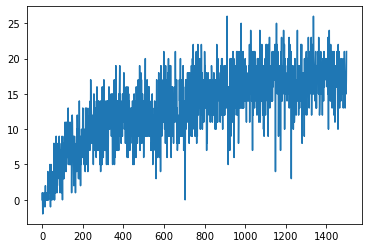

In [23]:
#Plots learning curve
plt.plot(score_list)

In [33]:
#Saves model weights
torch.save(agent.Q_Net.state_dict(), 'Navigation_Q_Net')

In [35]:
#Runs game with trained model and prints out score
agent = Agent(37,4, 0.98)
#Loads model weight
agent.Q_Net.load_state_dict(torch.load('Navigation_Q_Net')) 
#Sets epsilon to 0 since not training
agent.epsilon = 0
env_info = env.reset(train_mode=False)[brain_name]
s0 = env_info.vector_observations[0]       
score = 0
for frame in range(50000):
    action = agent.get_action(s0)
    env_info = env.step(int(action))[brain_name] 
    state = env_info.vector_observations[0]   
    reward = env_info.rewards[0]         
    score += reward
    done = env_info.local_done[0] 
    s0 = state
    if done:
        break
print(score)

17.0


In [32]:
sum(score_list[641:741])/100

13.05